<a href="https://colab.research.google.com/github/Michael-Zh/DAassignment4IK/blob/main/DA_assignment_IKEA_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Assignment - IKEA DA

Prepared by **Michael Zhang** | 2021 Mar | @AMSTERDAM

## 0. Executive Summary

### Question 1: Propose a segmentation analysis

A natural thought to segment the consumer is to use `clustering analysis`. With a relatively clean data... Seg A, B, C

### Question 3: Key segment(s) to focus to increase sales

Seg A
based on A, B, C reasons
* Increase sales is more of a short-term goal -> with the info I have, either focus on the large seg with potential to upsell (small improvement but big moneytory potential), or niche seg with great %growth potential

### Question 2: Potential data points to improve the analysis

* Unit info: understand if the product is of high unit price (which may not be purchased again in a short term)
* Category info: similar to above; also make it difficult to interpret the clustering
* Transactional info: what does it buy together per order -> basket analysis, frequency analysis, recency (3D of CLV or CV)


### Question 4: Prediction of the value in "HaveChildren" with vitualization

In [135]:
!pip install kneed

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
# from sklearn-extras
# from sk-learn-extra

In [137]:
## Build a data cleaning package/notebook

## 1. Data Import and Exploration
##### High-level descriptives
* **Sex**: 70% are Male
* **Age**: 35% are 26-35, followed by ~20% 18-25 and 36-45, respectively
* **CityType**: 50%+ from type C cities
* **YearsInCity**: 35% live 1-2 years, followed by 20% 2-3 years (other durations are close too)
* **Professions**: can roughly split into 3 tiers based on the customer count
* **HaveChildren**: 55% Customers do not have children (and 3.5% of them missing this information)

##### Load raw data and convert to proper data type

In [138]:
url = 'https://raw.githubusercontent.com/Michael-Zh/DAassignment4IK/main/RetailCustomerSales.csv'

# df = pd.read_csv(url,sep = ';', dtype = {'CustomerID':'category',
#                                          'ItemID':'category',
#                                           'Sex':'category',
#                                           'Age':'category',
#                                           'Profession':'category',
#                                           'CityType':'category',
#                                           'YearsInCity':'category',
#                                           'HaveChildren':'str',## to deal witht he NaN
#                                           'ItemCategory1':'str',
#                                           'ItemCategory2':'str',
#                                           'ItemCategory3':'str'})
# Categorical data is very slow in groupby

df = pd.read_csv(url,sep = ';', dtype = {'CustomerID':'str',
                                         'ItemID':'str',
                                          'Sex':'str',
                                          'Age':'str',
                                          'Profession':'str',
                                          'CityType':'str',
                                          'YearsInCity':'str',
                                          'HaveChildren':'str',## to deal witht he NaN
                                          'ItemCategory1':'str',
                                          'ItemCategory2':'str',
                                          'ItemCategory3':'str'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CustomerID     537577 non-null  object
 1   ItemID         537577 non-null  object
 2   Sex            537577 non-null  object
 3   Age            537577 non-null  object
 4   Profession     537577 non-null  object
 5   CityType       537577 non-null  object
 6   YearsInCity    537577 non-null  object
 7   HaveChildren   517407 non-null  object
 8   ItemCategory1  537577 non-null  object
 9   ItemCategory2  370591 non-null  object
 10  ItemCategory3  164278 non-null  object
 11  Amount         537577 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 49.2+ MB


##### Check duplicated rows

In [139]:
df.duplicated().sum()

0

##### Check Null value
Only HaveChildren col has NaN

In [140]:
print(df.isnull().sum())

CustomerID            0
ItemID                0
Sex                   0
Age                   0
Profession            0
CityType              0
YearsInCity           0
HaveChildren      20170
ItemCategory1         0
ItemCategory2    166986
ItemCategory3    373299
Amount                0
dtype: int64


##### Check potential outliers

In [141]:
consumer_spend = df.groupby('CustomerID')['Amount'].sum().sort_values()
consumer_spend.describe()

count    5.891000e+03
mean     8.517515e+05
std      9.329978e+05
min      4.410800e+04
25%      2.349140e+05
50%      5.126120e+05
75%      1.099005e+06
max      1.053678e+07
Name: Amount, dtype: float64

In [273]:
consumer_spend['Amount'].quantile(0.8)

1316414.0

In [274]:
consumer_spend['Amount'].quantile(0.4)

378500.0

In [278]:
consumer_spend.loc[(consumer_spend['Amount']<=consumer_spend['Amount'].quantile(0.8)) & (consumer_spend['Amount']>consumer_spend['Amount'].quantile(0.5)),].sum()/consumer_spend['Amount'].sum()

Amount    0.294426
dtype: float64

identify the top 3 dots in the box plot and remove them as outlier: > 7M

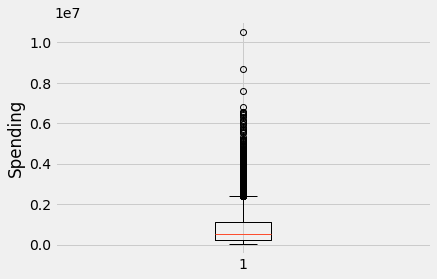

In [142]:
plt.style.use("fivethirtyeight")
plt.boxplot(consumer_spend)
plt.ylabel("Spending")
plt.show()

In [143]:
## Numeric Outlier: set IQR to filter out the outlier
## Ref: https://quantdare.com/isolation-forest-algorithm/
## Ref: https://www.kdnuggets.com/2018/12/four-techniques-outlier-detection.html
## Ref: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

## A bit too agreesive
# IQR = (75%-25%)*1.5(k)
# consumer_spend.loc[consumer_spend['Amount'] >= IQR, 'split'] = 'Outlier'
# consumer_spend.loc[consumer_spend['Amount'] < IQR, 'split'] = 'Inliner' 

# consumer_qtile = consumer_spend.groupby('split')['Amount'].sum()
# consumer_qtile

In [144]:
## From the box plot, try to exclude only the top 3 dot
## Check the top 10 amount -> identify the top dots in the box plot
consumer_spend = pd.DataFrame(consumer_spend)
consumer_spend['Amount'].sort_values(ascending=False).head(10)

CustomerID
1004277    10536783
1001680     8699232
1002909     7577505
1001941     6817493
1000424     6573609
1004448     6565878
1001015     6511302
1003391     6476786
1001181     6387899
1000549     6310604
Name: Amount, dtype: int64

In [145]:
consumer_spend_outlier = consumer_spend['Amount'].sort_values(ascending=False).iloc[:3].index.tolist()
consumer_spend_outlier

['1004277', '1001680', '1002909']

In [146]:
# len(df['ItemID'].unique())
item_consumer = df.groupby('ItemID')['CustomerID'].nunique().sort_values()
item_consumer.describe()

count    3623.000000
mean      148.378968
std       208.176730
min         1.000000
25%        19.000000
50%        70.000000
75%       192.000000
max      1858.000000
Name: CustomerID, dtype: float64

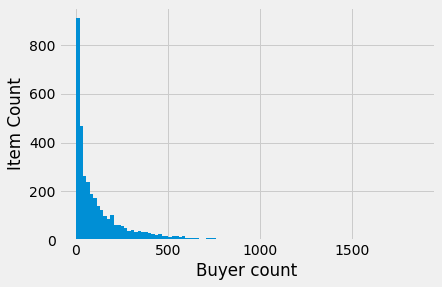

In [147]:
#plot popular product and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_consumer, bins = 100)
plt.xlabel("Buyer count")
plt.ylabel("Item Count")
plt.show()

In [148]:
# len(df['ItemID'].unique())
item_sales = df.groupby('ItemID')['Amount'].sum().sort_values()
item_sales.describe()

#plot high sales value

count    3.623000e+03
mean     1.384948e+06
std      2.608237e+06
min      4.050000e+02
25%      1.143055e+05
50%      4.352640e+05
75%      1.503716e+06
max      2.753243e+07
Name: Amount, dtype: float64

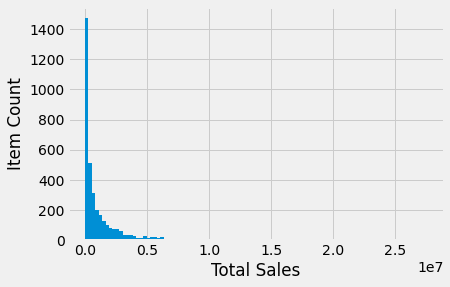

In [149]:
#plot high total sales value and check distribution
plt.style.use("fivethirtyeight")
plt.hist(item_sales, bins = 100)
plt.xlabel("Total Sales")
plt.ylabel("Item Count")
plt.show()

##### Other descriptives

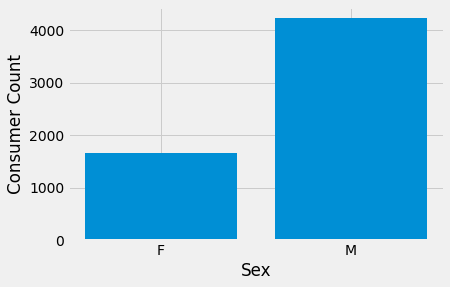

In [150]:
sex = df.groupby('Sex')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(sex.index, sex)
plt.xlabel("Sex")
plt.ylabel("Consumer Count")
plt.show()

In [151]:
round(sex/sex.sum()*100,1)

Sex
F    28.3
M    71.7
Name: CustomerID, dtype: float64

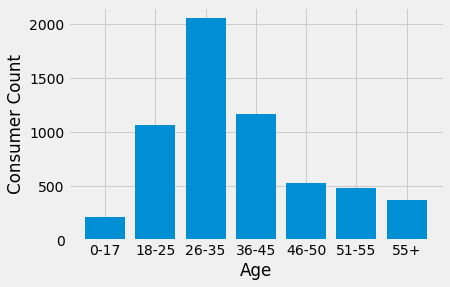

In [152]:
age = df.groupby('Age')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(age.index, age)
plt.xlabel("Age")
plt.ylabel("Consumer Count")
plt.show()

## Main consumer base is aroudn 26-35 YO

In [153]:
round(age/age.sum()*100,1)

Age
0-17      3.7
18-25    18.1
26-35    34.8
36-45    19.8
46-50     9.0
51-55     8.2
55+       6.3
Name: CustomerID, dtype: float64

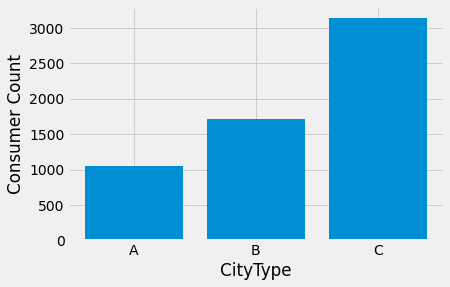

In [154]:
CityType = df.groupby('CityType')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(CityType.index, CityType)
plt.xlabel("CityType")
plt.ylabel("Consumer Count")
plt.show()

In [155]:
round(CityType/CityType.sum()*100,1)

CityType
A    17.7
B    29.0
C    53.3
Name: CustomerID, dtype: float64

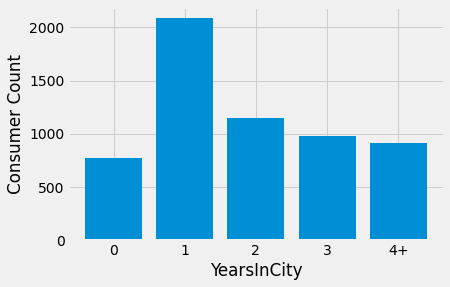

In [156]:
YearsInCity = df.groupby('YearsInCity')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(YearsInCity.index, YearsInCity)
plt.xlabel("YearsInCity")
plt.ylabel("Consumer Count")
plt.show()

In [157]:
round(YearsInCity/YearsInCity.sum()*100,1)

YearsInCity
0     13.1
1     35.4
2     19.4
3     16.6
4+    15.4
Name: CustomerID, dtype: float64

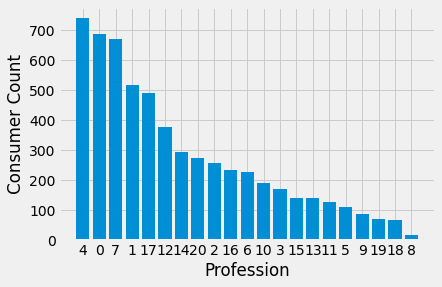

In [158]:
Profession = df.groupby('Profession')['CustomerID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.bar(Profession.index, Profession)
plt.xlabel("Profession")
plt.ylabel("Consumer Count")
plt.show()

In [159]:
round(Profession/Profession.sum()*100,1)

Profession
4     12.6
0     11.7
7     11.4
1      8.8
17     8.3
12     6.4
14     5.0
20     4.6
2      4.3
16     4.0
6      3.9
10     3.3
3      2.9
15     2.4
13     2.4
11     2.2
5      1.9
9      1.5
19     1.2
18     1.1
8      0.3
Name: CustomerID, dtype: float64

Since the missing records account for a small subset (3.6%), consider remove it from the clustering

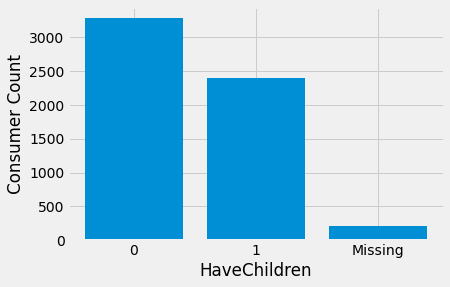

In [160]:
df_c = df.copy()
df_c['HaveChildren'] = df_c['HaveChildren'].fillna('Missing')
HaveChildren = df_c.groupby('HaveChildren')['CustomerID'].nunique().sort_index()
plt.style.use("fivethirtyeight")
plt.bar(HaveChildren.index, HaveChildren)
plt.xlabel("HaveChildren")
plt.ylabel("Consumer Count")
plt.show()

In [161]:
round(HaveChildren/HaveChildren.sum()*100,1)

HaveChildren
0          55.7
1          40.7
Missing     3.6
Name: CustomerID, dtype: float64

###### Check how the category columns structure

In [162]:
df.loc[df['ItemCategory1'] == df['ItemCategory2'],'ItemID'].unique()
## cat start small

array([], dtype=object)

##### Convert the category combination to one column
Category 5 and 8 has both very high # of unique items and high sales

In [163]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

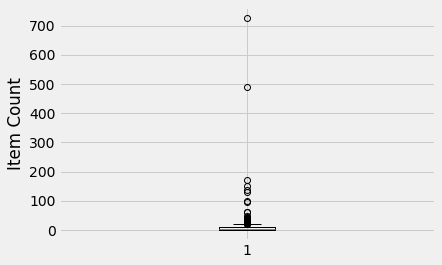

In [164]:
ItemCombo = df_combo.groupby(['CatCombo'])['ItemID'].nunique().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemCombo)
plt.ylabel("Item Count")
plt.show()

In [165]:
ItemCombo.head(5)

CatCombo
8_N_N     727
5_N_N     488
11_N_N    171
5_8_N     150
5_14_N    136
Name: ItemID, dtype: int64

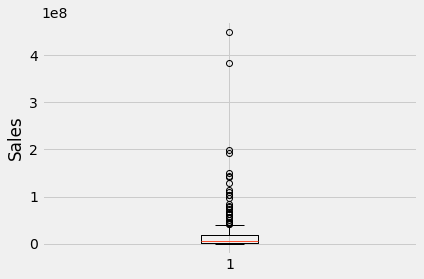

In [166]:
ItemComboSales = df_combo.groupby(['CatCombo'])['Amount'].sum().sort_values(ascending=False)
plt.style.use("fivethirtyeight")
plt.boxplot(ItemComboSales)
plt.ylabel("Sales")
plt.show()

In [167]:
ItemComboSales.head(5)

CatCombo
8_N_N     449437193
5_N_N     383126455
1_16_N    198147606
1_2_15    191990411
5_8_N     149089678
Name: Amount, dtype: int64

## 2. Segmentation (Clustering Analysis)
#### Data Cleaning and Preprocessing

* The dataset is clean overall

* Only `HaveChildren` column has `NaN` values. Since it accounts for a small subset, they were dropped for clustering

* Three outliers were removed (3 customers of exceptionally high total spending)  

* Preprocessing of categorical data is shown below. In the actual clustering, `Profession` and `ItemCategory` columns were not used:
 * **Sex**: code `M` to `1` and `F` to `0`
 * **Age**: replace to mean of upper and lower boundary. Assign `17` to `0-17` and `55` for `55+`
<!--  (as 16 is normally the lowest age we can legally target) -->
 * **CityType**: `A` as `1`, `B` as `2` and `C` as `3`
 * **YearsInCity**: convert to numeric; `4+` as `4`
 * **HaveChildren**: `N` as `-1`, `NaN` as `0` and `Y` as `1`  
 * **Profession**: one-hot encoding to 21 individual features with `1` or `0` values
 * **ItemCategory**: combine all three columns into one `CatCombo`, coded as `ItemCategory1_ItemCategory2_ItemCategory3` (resulting in 235 new categories/category combinations)
* Normalize all features

#### Considerations of clustering model/feature selection
* The classic and popular `K-means` clustering method was chosen 
* Initially, `Profession` and `ItemCategory` were included in the clustering. However, the model performed poorly and the model significantly improved after the exclusion of these two sets of features. For the demonstration purpose, `TotalSpending` already represents a high level purchasing behavior and monetory value of a particular customer. Inclusion of these features is possible if given more time to explore different models/data transformation.
<!-- What's more, even if we have a well-perform model, due to a lack of description of these two features, it limits a meaningful interpretation of  -->

### 2.1 Data Preparation
##### **Obtain demographic labels with `groupby` and save it as `df_demo`**

In [197]:
df_gb = df.copy()
df_gb = df_gb.groupby(['CustomerID','Sex','Age','Profession',\
                       'CityType','YearsInCity','HaveChildren'],dropna=False)['Amount']\
                       .sum().reset_index().set_index('CustomerID')
df_gb = df_gb.rename(columns={'Amount':'TotalSpending'})
df_gb.head()

,Sex,Age,Profession,CityType,YearsInCity,HaveChildren,TotalSpending
CustomerID,,,,,,,
1000001,F,0-17,10,A,2,0,333481
1000002,M,55+,16,C,4+,0,810353
1000003,M,26-35,15,A,3,0,341635
1000004,M,46-50,7,B,2,1,205987
1000005,M,26-35,20,A,1,1,821001


Create mapping for `Sex`, `Age`, `CityType`, `YearsInCity` and `HaveChildren`

In [169]:
replace_map = {'Sex': {'M': 1, 'F': 0},
               'Age': {'0-17': 17, '18-25': 21.5, '26-35': 30.5, '36-45': 40.5,
                       '46-50': 48, '51-55': 53, '55+': 55},
               'CityType': {'A': 1, 'B': 2, 'C': 3},
               'YearsInCity': {'0': 0, '1': 1, '2': 2, '3':3, '4+':4},
               'HaveChildren': {'0': -0.5, '1': 0.5}}

Replace the value with the mapping above

In [170]:
df_demo = df_gb.copy()
df_demo.replace(replace_map, inplace=True)
df_demo.drop(columns='Profession', inplace=True)

print(df_demo.head())

            Sex   Age  CityType  YearsInCity  HaveChildren  TotalSpending
CustomerID                                                               
1000001       0  17.0         1            2          -0.5         333481
1000002       1  55.0         3            4          -0.5         810353
1000003       1  30.5         1            3          -0.5         341635
1000004       1  48.0         2            2           0.5         205987
1000005       1  30.5         1            1           0.5         821001


In [171]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1000001 to 1006040
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            5891 non-null   int64  
 1   Age            5891 non-null   float64
 2   CityType       5891 non-null   int64  
 3   YearsInCity    5891 non-null   int64  
 4   HaveChildren   5679 non-null   float64
 5   TotalSpending  5891 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 322.2+ KB


##### **Create one-hot encoding for `Professions` and save it as `df_prof`** (this feature is not used in the clustering)

In [172]:
df_prof = df_gb.copy().reset_index().set_index('CustomerID')
df_prof.drop(columns=['Sex','Age','CityType','YearsInCity','HaveChildren','TotalSpending'], inplace=True)
df_prof = pd.get_dummies(df_prof, columns=['Profession'], prefix = ['Prof'])

print(df_prof.head())

            Prof_0  Prof_1  Prof_10  Prof_11  ...  Prof_6  Prof_7  Prof_8  Prof_9
CustomerID                                    ...                                
1000001          0       0        1        0  ...       0       0       0       0
1000002          0       0        0        0  ...       0       0       0       0
1000003          0       0        0        0  ...       0       0       0       0
1000004          0       0        0        0  ...       0       1       0       0
1000005          0       0        0        0  ...       0       0       0       0

[5 rows x 21 columns]


##### **Combine three `ItemCategory` columns to `CatCombo` and save it as `df_combo`** (this feature is not used in the clustering, but it is included in the descriptive analysis)

In [173]:
df_combo = df.copy()

df_combo['ItemCategory2'].fillna('N', inplace=True)
df_combo['ItemCategory3'].fillna('N', inplace=True)

df_combo['CatCombo'] = df_combo['ItemCategory1']+'_'\
                       +df_combo['ItemCategory2']+'_'\
                       +df_combo['ItemCategory3']

print(df_combo.sort_values(['CatCombo']).head())

       CustomerID     ItemID Sex  ... ItemCategory3 Amount  CatCombo
137562    1003292  P00308042   F  ...             N  19206   10_11_N
409858    1003110  P00346542   M  ...            16   4932  10_13_16
3908      1000645  P00116142   M  ...            16  23395  10_13_16
220120    1003934  P00161842   M  ...            16   4627  10_13_16
130594    1002049  P00116142   F  ...            16  14258  10_13_16

[5 rows x 13 columns]


Pivot the `CatCombo` column to wide format, resulting in each row respresenting a unique `CustomerID` and each columns contains its spending in each category combo

In [174]:
df_combo = pd.pivot_table(df_combo, values=['Amount'], index=['CustomerID'],\
                          columns=['CatCombo'], aggfunc=np.sum, fill_value=0)\
                          .reset_index().set_index('CustomerID').droplevel(0, axis=1)

df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1000001 to 1006040
Columns: 235 entries, 10_11_N to 9_N_N
dtypes: int64(235)
memory usage: 10.6+ MB


In [175]:
print(df_combo.head())

CatCombo    10_11_N  10_13_16  10_13_N  10_14_16  ...  8_9_N   8_N_N  9_15_N  9_N_N
CustomerID                                        ...                              
1000001           0         0        0         0  ...      0   59604       0      0
1000002           0         0        0         0  ...      0  152360       0      0
1000003           0         0        0         0  ...      0       0       0      0
1000004           0         0        0         0  ...      0       0       0      0
1000005           0         0        0         0  ...      0  174152       0      0

[5 rows x 235 columns]


##### **Complie all the features**

In [176]:
# df_compile = df_demo.join([df_prof, df_combo])
df_compile = df_demo.join(df_combo)
print(df_compile.head(5))

            Sex   Age  CityType  YearsInCity  ...  8_9_N   8_N_N  9_15_N  9_N_N
CustomerID                                    ...                              
1000001       0  17.0         1            2  ...      0   59604       0      0
1000002       1  55.0         3            4  ...      0  152360       0      0
1000003       1  30.5         1            3  ...      0       0       0      0
1000004       1  48.0         2            2  ...      0       0       0      0
1000005       1  30.5         1            1  ...      0  174152       0      0

[5 rows x 241 columns]


In [177]:
df_compile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5891 entries, 1000001 to 1006040
Columns: 241 entries, Sex to 9_N_N
dtypes: float64(2), int64(239)
memory usage: 11.0+ MB


Drop missing value in `HaveChildren`

In [178]:
df_dropna = df_compile.dropna(subset=['HaveChildren'])
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5679 entries, 1000001 to 1006040
Columns: 241 entries, Sex to 9_N_N
dtypes: float64(2), int64(239)
memory usage: 10.5+ MB


Drop outliers (`TotalSpending` >= 7M)

In [179]:
df_inliner = df_dropna.drop(consumer_spend_outlier)
df_inliner.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5676 entries, 1000001 to 1006040
Columns: 241 entries, Sex to 9_N_N
dtypes: float64(2), int64(239)
memory usage: 10.5+ MB


In [180]:
df_inliner.head()

,Sex,Age,CityType,YearsInCity,HaveChildren,TotalSpending,10_11_N,10_13_16,10_13_N,10_14_16,10_15_16,10_15_N,10_16_N,10_N_N,11_13_16,11_13_N,11_14_N,11_15_16,11_15_N,11_16_N,11_N_N,12_14_17,12_14_N,12_17_N,12_N_N,13_14_16,13_15_16,13_15_N,13_16_N,13_N_N,14_16_N,14_17_N,14_18_N,14_N_N,15_16_17,15_16_N,15_17_N,15_N_N,16_N_N,17_N_N,...,6_11_N,6_13_N,6_16_N,6_8_10,6_8_13,6_8_14,6_8_15,6_8_16,6_8_N,6_N_N,7_12_N,7_17_N,7_8_N,7_N_N,8_10_16,8_10_N,8_11_16,8_11_N,8_12_17,8_12_N,8_13_14,8_13_15,8_13_16,8_13_N,8_14_15,8_14_16,8_14_17,8_14_18,8_14_N,8_15_16,8_15_N,8_16_17,8_16_N,8_17_N,8_18_N,8_9_14,8_9_N,8_N_N,9_15_N,9_N_N
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,0,17.0,1,2,-0.5,333481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1057,0,3137,0,0,0,0,0,0,0,0,11011,0,0,0,0,16446,0,...,0,0,0,0,0,0,0,16622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9938,0,0,0,59604,0,0
1000002,1,55.0,3,4,-0.5,810353,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,15952,0,0,0,0,74043,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9899,0,8017,0,16001,0,17865,6187,0,0,0,152360,0,0
1000003,1,30.5,1,3,-0.5,341635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5817,0,0,0,0,0,0,0
1000004,1,48.0,2,2,0.5,205987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000005,1,30.5,1,1,0.5,821001,0,0,0,0,0,0,0,0,4653,0,0,0,0,0,5895,0,0,0,0,0,0,0,0,0,0,0,0,11085,0,17374,0,0,25195,0,...,4240,0,8232,0,0,0,0,16244,20603,16421,0,0,0,74954,0,0,0,0,0,4004,0,0,4263,7913,0,6181,0,0,28140,0,7803,0,20245,7850,0,0,0,174152,0,0


### 2.2 K-mean Clustering

In [ ]:
## Ref: https://antonsruberts.github.io/kproto-audience/
## Ref: https://en.wikipedia.org/wiki/RFM_(market_research)

##### **Build the pipeline**

In [232]:
def KMeanCluster(n, data):
    
    preprocessor = Pipeline(
        [
            ("scaler", StandardScaler())#MinMaxScaler())
        ]
    )

    clusterer = Pipeline(
       [
           (
               "kmeans",
               KMeans(
                   n_clusters=n,
                   init="k-means++",
                   n_init=50,
                   max_iter=500,
                   random_state=99,
               ),
           ),
       ]
    )

    pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("clusterer", clusterer)
        ]
    )

    pipe.fit(data)
    
    preprocessed_data = pipe["preprocessor"].transform(data)

    predicted_labels = pipe["clusterer"]["kmeans"].labels_

    sse = pipe["clusterer"]["kmeans"].inertia_
    
    ss = silhouette_score(preprocessed_data, predicted_labels)

    return predicted_labels, sse, ss

##### **Vectorize the data**

In [222]:
features = df_combo.to_numpy() 
features

array([[     0,      0,      0, ...,  59604,      0,      0],
       [     0,      0,      0, ..., 152360,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       ...,
       [     0,      0,      0, ...,   6039,      0,      0],
       [     0,  18731,  23727, ...,  27520,      0,      0],
       [     0,  23251,      0, ..., 277251,  13719,      0]])

##### **Run the model**

In [233]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []
predicted_labels = []
sseList = []
    
for k in range(2, 11):
    pred_labels, sse, ss = KMeanCluster(k, features)
    silhouette_coefficients.append(ss)
    predicted_labels.append(pred_labels)
    sseList.append(sse)

##### **Evaluate the models and choose right number of clusters**
Based on `SC` and `SSE` metrics, `4` or `5` clusters appear to be sensible numbers

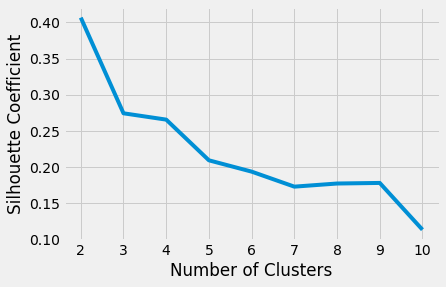

In [234]:
## Determine the max(sc) from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

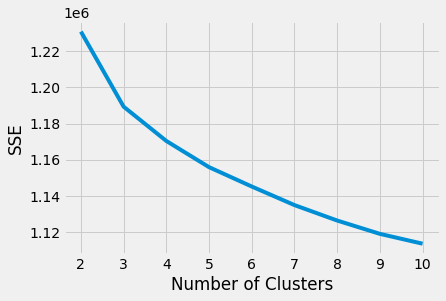

In [235]:
# ## Determine the elbow from plot
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sseList)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [236]:
## Determine the elbow programmatically
kl = KneeLocator(
    range(2, 11), sseList, curve="convex", direction="decreasing"
)

kl.elbow

4

### 2.3 Descriptives of each cluster

##### Assigning labels to each row

In [279]:
# df_clustered = df_gb.iloc[:,:7].join(df_combo)
# df_clustered['cluster'] = predicted_labels[1]

# for col in ['Sex','Age','Profession','CityType','YearsInCity','HaveChildren','cluster']:
#     df_clustered[col] = df_clustered[col].astype('category')

# df_clustered = df_clustered.reset_index()
# df_clustered.groupby('cluster')['CustomerID'].count()

In [280]:
df_clustered = df_gb.iloc[:,:7].join(df_combo)
df_clustered['cluster'] = predicted_labels[2]

for col in ['Sex','Age','Profession','CityType','YearsInCity','HaveChildren','cluster']:
    df_clustered[col] = df_clustered[col].astype('category')

df_clustered = df_clustered.reset_index()
df_clustered.groupby('cluster')['CustomerID'].count()

cluster
0     784
1    4078
2     290
3     739
Name: CustomerID, dtype: int64

In [281]:
# df_clustered = df_gb.iloc[:,:7].join(df_combo)
# df_clustered['cluster'] = predicted_labels[3]

# for col in ['Sex','Age','Profession','CityType','YearsInCity','HaveChildren','cluster']:
#     df_clustered[col] = df_clustered[col].astype('category')

# df_clustered = df_clustered.reset_index()
# df_clustered.groupby('cluster')['CustomerID'].count()

In [282]:
## customer counts in each cluster
df_clustered.groupby(['cluster','Sex'])['CustomerID'].count()#/df_clustered.groupby('cluster')['CustomerID'].count()*100

cluster  Sex
0        F       107
         M       677
1        F      1265
         M      2813
2        F        53
         M       237
3        F       241
         M       498
Name: CustomerID, dtype: int64

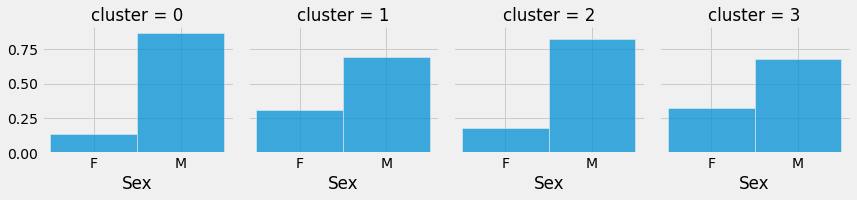

In [283]:
g0 = sns.FacetGrid(df_clustered, col="cluster")
g0.map(sns.histplot,'Sex',stat="density", common_norm=False)
# g1.fig

In [284]:
## customer counts in each cluster
df_clustered.groupby(['cluster','CityType'])['CustomerID'].count()/len(df_clustered)*100

cluster  CityType
0        A            2.359531
         B            5.618740
         C            5.330165
1        A           10.252928
         B           14.853166
         C           44.118146
2        A            2.053981
         B            2.868783
         C            0.000000
3        A            3.072483
         B            5.635715
         C            3.836361
Name: CustomerID, dtype: float64

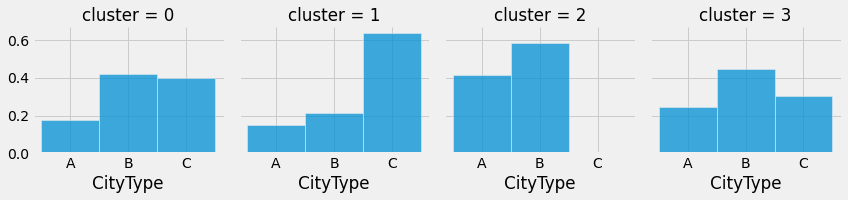

In [285]:
g1 = sns.FacetGrid(df_clustered, col="cluster")
g1.map(sns.histplot,'CityType',stat="density", common_norm=False)
# g1.fig

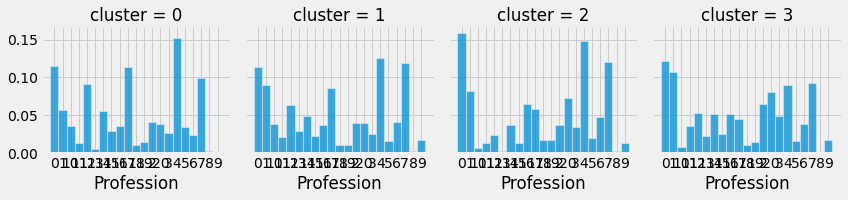

In [286]:
## Difficult to interpret - optentially related to income level/education etc.
g2 = sns.FacetGrid(df_clustered, col="cluster")
g2.map(sns.histplot,'Profession',stat="density", common_norm=False)
# g2.fig

In [287]:
# ## customer aounts in each cluster
# df_clustered.groupby(['cluster'])['Age'].mean()

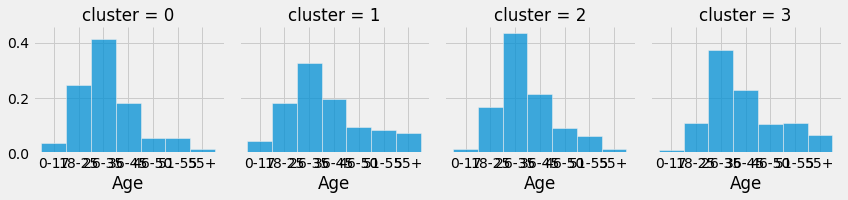

In [288]:
g3 = sns.FacetGrid(df_clustered, col="cluster")
g3.map(sns.histplot,'Age',stat="density", common_norm=False)
# g3.fig

In [289]:
## customer counts in each cluster
df_clustered.groupby(['cluster','YearsInCity'])['YearsInCity'].count()

cluster  YearsInCity
0        0               100
         1               264
         2               170
         3               139
         4+              111
1        0               534
         1              1451
         2               803
         3               665
         4+              625
2        0                41
         1                95
         2                47
         3                55
         4+               52
3        0                97
         1               276
         2               125
         3               120
         4+              121
Name: YearsInCity, dtype: int64

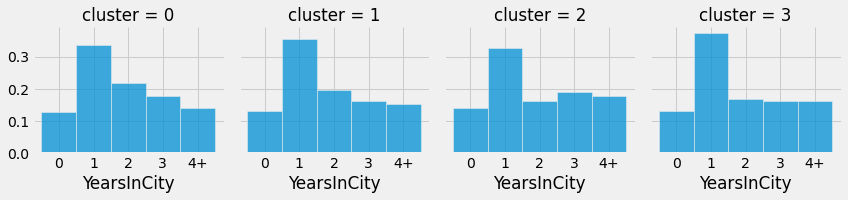

In [290]:
g4 = sns.FacetGrid(df_clustered, col="cluster")
g4.map(sns.histplot,'YearsInCity',stat="density", common_norm=False)
# g3.fig

In [291]:
## customer counts in each cluster
df_clustered.groupby(['cluster','HaveChildren'])['CustomerID'].count()/len(df_clustered)

cluster  HaveChildren
0        0               0.078594
         1               0.049397
1        0               0.383297
         1               0.284162
2        0               0.028348
         1               0.019182
3        0               0.066542
         1               0.054490
Name: CustomerID, dtype: float64

ConversionError: ignored

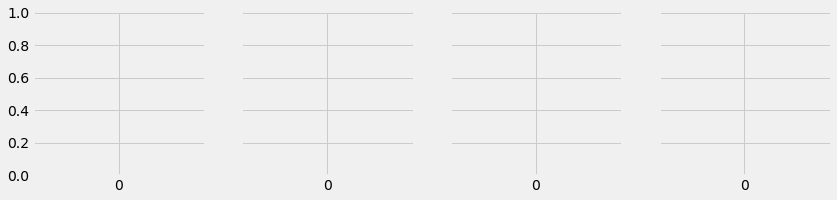

In [292]:
g5 = sns.FacetGrid(df_clustered, col="cluster")
g5.map(sns.histplot,'HaveChildren')
# g3.fig

In [293]:
df_clustered.groupby(['cluster'])['TotalSpending'].mean()

cluster
0    1.549991e+06
1    3.856547e+05
2    3.791007e+06
3    1.529612e+06
Name: TotalSpending, dtype: float64

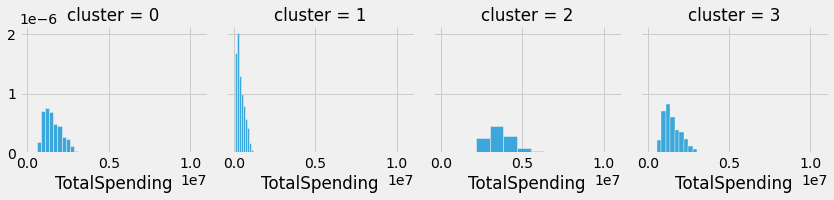

In [294]:
g6 = sns.FacetGrid(df_clustered, col="cluster")
g6.map(sns.histplot,'TotalSpending',stat="density", common_norm=False, bins=10)
# g3.fig